In [1]:
import pandas as pd
import numpy as np
import pickle
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from datetime import datetime
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from CustomModels import BetaRegression, LinearLimitedRegression
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [2]:
dateparse = lambda x: datetime.strptime(x, '%Y/%m/%d') if isinstance(x, str) else x

In [3]:
# Load the data
data = pd.read_excel('SignedPlayersDatasetVALORANT.xlsx', parse_dates=['date'], date_parser=dateparse)
# Fix name errors
data = data.replace('\n','', regex=True)
data = data.replace(' ','', regex=True)
#test_data = pd.read_excel('Test Dataset VALORANT VCT DATASET.xlsx', parse_dates=['date'], date_parser=dateparse).dropna(how='any',axis=0)

In [4]:
# Select features and target variable
input_features = ['date', 'player']
features = ['kills_per_round', 'assists_per_round', 'average_damage_per_round',
            'first_kills_per_round', 'first_deaths_per_round', 'headshot_percentage',
            'clutch_success_percentage', 'total_kills', 'total_deaths', 'total_assists',
            'total_first_kills', 'total_first_deaths']
target_variable = 'average_combat_score'
#Note: create models w/ target variable for rounds and rating

In [5]:
"""
# Split variables
X_train = data[features]
X_test = test_data[features]
y_train = data[target_variable]
y_test = test_data[target_variable]
"""
None

In [6]:
# Get dates and players
dates = data['date'].unique()
players = data['player'].unique()

In [7]:
# For getting difference in months
def diff_month(d1, d2):
    return (d1.year - d2.year) * 12 + d1.month - d2.month

def months_from_2021(dates):
    months_from_Jan_2021 = []
    for date in dates:
        months_from_Jan_2021.append(diff_month(date, datetime.strptime('2021/01/01', '%Y/%m/%d')))
    return months_from_Jan_2021

In [8]:
data = data.assign(months_from_Jan_2021 = months_from_2021(data['date']))

In [9]:
#Create regression model for each feature for each players
#Note: Unknown players don't work.
#Note: Used decision tree regression due to small sample per player. Problem stops predicting past latest event
player_feature_models = {}
for player in players:
    player_feature_model = {}
    player_data = data.loc[data['player'] == player]
    for feature in features:
        feature_model = DecisionTreeRegressor(max_depth=3).fit(player_data['months_from_Jan_2021'].values[:,np.newaxis], player_data[feature])
        player_feature_model.update({feature:feature_model})
    player_feature_models.update({player:player_feature_model})

In [10]:
#Create regression model for each feature for each players
#Note: Unknown players don't work.
#Note: Used decision tree regression due to problems in prediction and small sample per player. Can cause negative values
player_feature_models_linear = {}
for player in players:
    player_feature_model = {}
    player_data = data.loc[data['player'] == player]
    for feature in features:
        feature_model = LinearRegression().fit(player_data['months_from_Jan_2021'].values[:,np.newaxis], player_data[feature])
        player_feature_model.update({feature:feature_model})
    player_feature_models_linear.update({player:player_feature_model})

In [71]:
player_data = data.loc[data['player'] == 'TenZ']
player_data['months_from_Jan_2021'].values[:,np.newaxis]

array([[ 4],
       [ 8],
       [11],
       [25]], dtype=int64)

In [21]:
player_data['months_from_Jan_2021'].values

array([21, 25, 29], dtype=int64)

In [72]:
player_data

,date,player,rounds,rating,average_combat_score,kills_deaths,average_damage_per_round,kills_per_round,assists_per_round,first_kills_per_round,first_deaths_per_round,headshot_percentage,clutch_success_percentage,total_kills,total_deaths,total_assists,total_first_kills,total_first_deaths,months_from_Jan_2021,kills_per_round_transformed
118,2021-05-30,TenZ,201,1.35,289.4,1.48,170.3,1.02,0.27,0.20,0.09,0.20,0.11,206,139,55,41,18,4,1.000000
119,2021-09-19,TenZ,243,1.25,269.5,1.38,166.7,0.94,0.19,0.15,0.14,0.21,0.13,229,166,47,36,33,8,0.876923
120,2021-12-12,TenZ,199,1.12,225.2,1.06,144.4,0.76,0.19,0.20,0.15,0.20,0.13,152,143,38,40,29,11,0.600000
121,2023-02-13,TenZ,39,0.98,183.5,0.96,122.4,0.67,0.21,0.13,0.15,0.23,0.50,26,27,8,5,6,25,0.461538


In [36]:
#Linear model on one feature and player
player_data = data.loc[data['player'] == 'TenZ']
feature = 'kills_per_round'
# Transform the response variable to be between 0 and 1
example_linear_feature_model = LinearRegression().fit(player_data['months_from_Jan_2021'].values[:,np.newaxis], player_data[feature])

In [37]:
player_data['months_from_Jan_2021'].values

array([ 4,  8, 11, 25], dtype=int64)

In [39]:
prediction_data = example_linear_feature_model.predict(player_data['months_from_Jan_2021'].values[:,np.newaxis])

array([0.97454, 0.91102, 0.86338, 0.64106])

0.97454

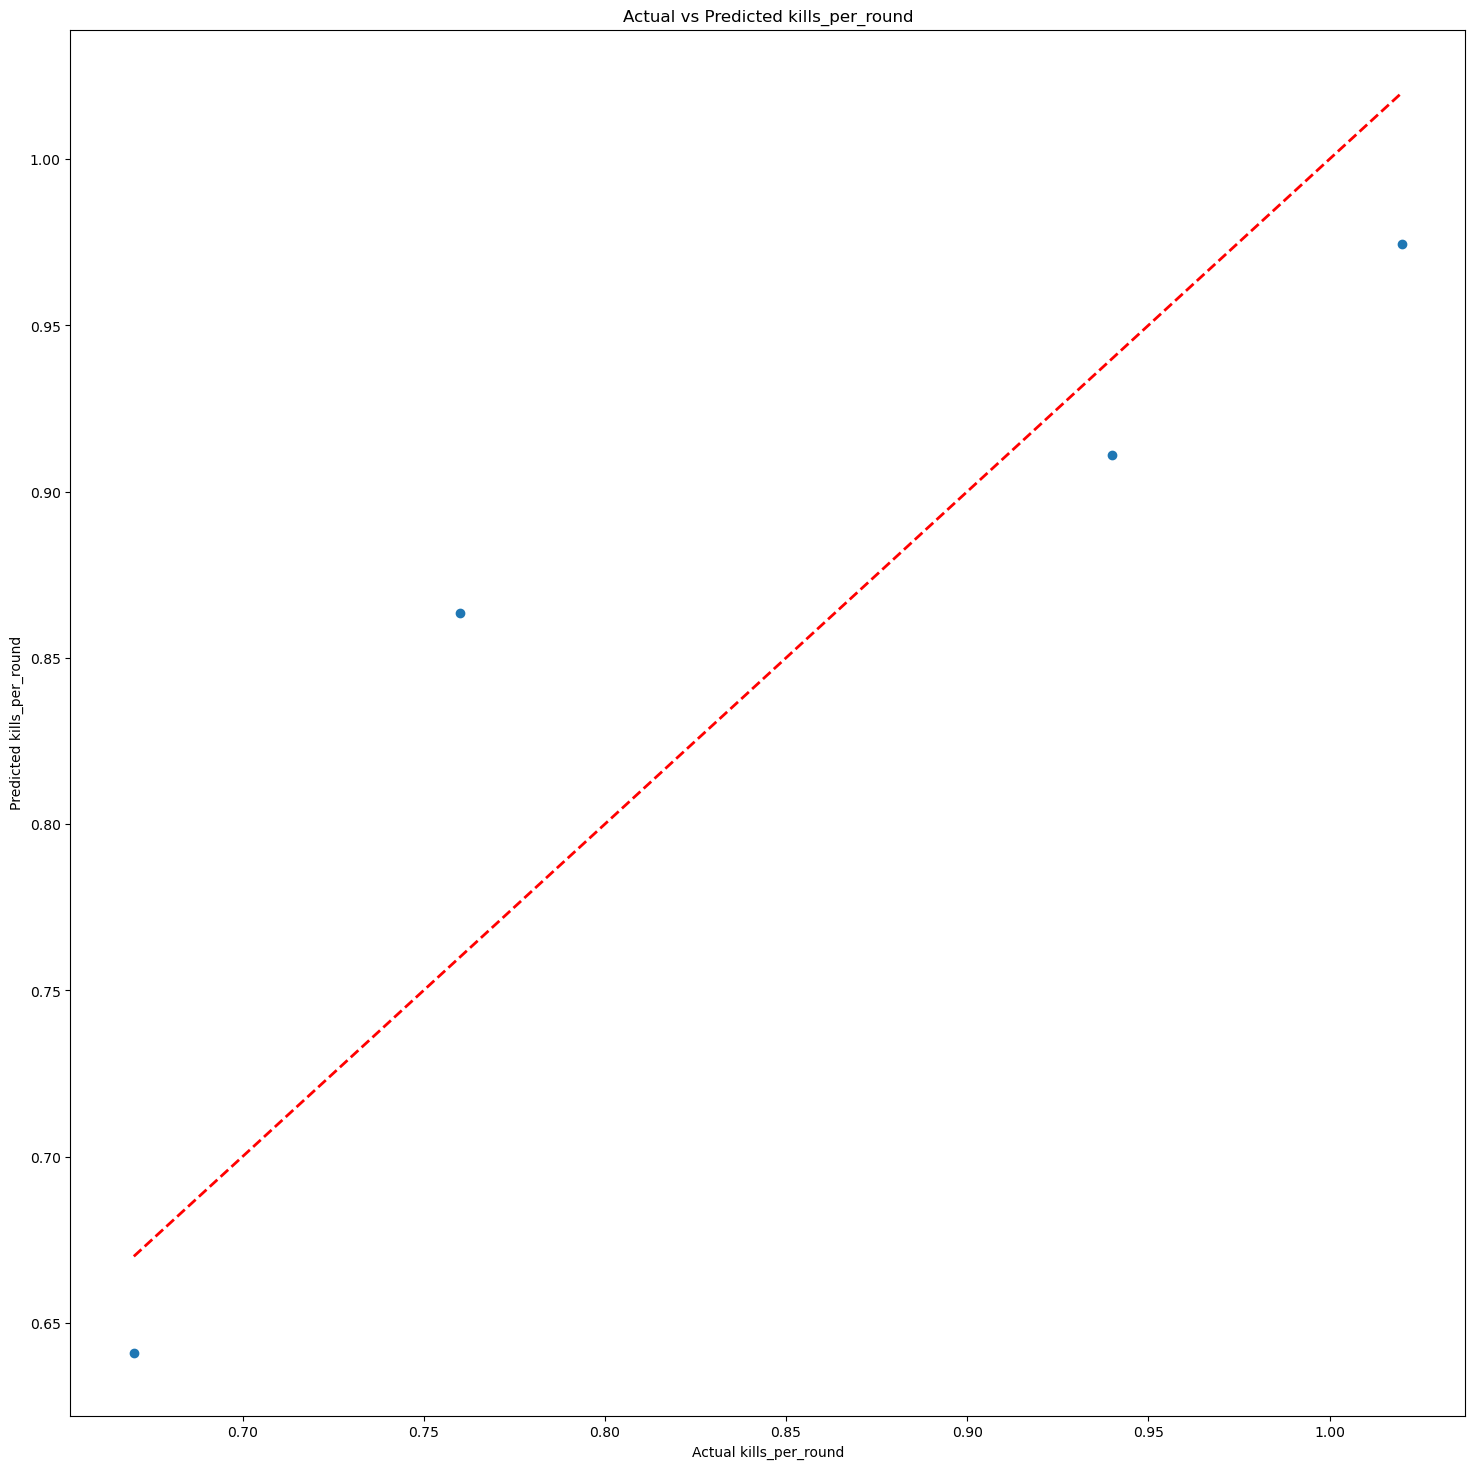

In [83]:
# Actual vs Predicted graph

# Create a larger figure
plt.figure(figsize=(18, 18))

prediction_data = example_linear_feature_model.predict(player_data['months_from_Jan_2021'].values[:,np.newaxis])

# Plot actual vs predicted values with player names
actual = player_data[feature]
plt.scatter(player_data[feature], prediction_data)
plt.plot([min(actual), max(actual)], [min(actual), max(actual)], linestyle='--', color='red', linewidth=2)
plt.xlabel("Actual kills_per_round")
plt.ylabel("Predicted kills_per_round")
plt.title("Actual vs Predicted kills_per_round")

plt.show()

In [ ]:
#Create regression model for each feature for each players
#Note: Unknown players don't work.
#Note: XGboost models can get very heavy in file size
player_feature_models_XGB = {}
for player in players:
    player_feature_model = {}
    player_data = data.loc[data['player'] == player]
    for feature in features:
        feature_model = XGBRegressor().fit(player_data['months_from_Jan_2021'].values[:,np.newaxis], player_data[feature])
        player_feature_model.update({feature:feature_model})
    player_feature_models_XGB.update({player:player_feature_model})

In [28]:
#Note uses beta regression which limits the max/min values
player_feature_models_beta = {}
for player in players:
    player_feature_model = {}
    player_data = data.loc[data['player'] == player]
    for feature in features:
        player_feature_model_beta = BetaRegression(player_data, feature)
        feature_model = player_feature_model_beta.fit(player_data['months_from_Jan_2021'], player_data[feature])
        player_feature_model.update({feature:feature_model})
    player_feature_models_beta.update({player:player_feature_model})

In [18]:
#Beta model on one feature and player
player_data = data.loc[data['player'] == 'TenZ']
feature = 'kills_per_round'
feature_min = data[feature].min()
feature_max = data[feature].max()
# Transform the response variable to be between 0 and 1
player_data[feature+'_transformed'] = (data[feature] - feature_min) / (feature_max - feature_min)
example_feature_model = sm.OLS(player_data[feature+'_transformed'], sm.add_constant(player_data['months_from_Jan_2021'])).fit()

C:\Users\adban\AppData\Local\Temp\ipykernel_8492\2802709425.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data[feature+'_transformed'] = (data[feature] - feature_min) / (feature_max - feature_min)


In [19]:
player_data[feature+'_transformed']

118    1.000000
119    0.876923
120    0.600000
121    0.461538
Name: kills_per_round_transformed, dtype: float64

In [20]:
example_feature_model

In [21]:
prediction_data = example_feature_model.predict(sm.add_constant(player_data['months_from_Jan_2021']))

In [22]:
example_feature_model.predict(sm.add_constant(data['months_from_Jan_2021'].unique()))

array([0.51473846, 0.5636    , 0.41701538, 0.83233846, 0.19713846,
       0.31929231, 0.75904615, 0.93006154])

In [23]:
data['months_from_Jan_2021'].unique()

array([21, 19, 25,  8, 34, 29, 11,  4], dtype=int64)

In [24]:
example_feature_model.predict(sm.add_constant(np.array([21, 23, 24])))

array([0.51473846, 0.46587692, 0.44144615])

In [25]:
prediction_data

118    0.930062
119    0.832338
120    0.759046
121    0.417015
dtype: float64

In [26]:
prediction_data_actual = prediction_data * (feature_max - feature_min) + feature_min

In [27]:
prediction_data_actual

118    0.97454
119    0.91102
120    0.86338
121    0.64106
dtype: float64

In [28]:
prediction_data_all = example_feature_model.predict(sm.add_constant(data['months_from_Jan_2021'].unique()))

In [29]:
data['months_from_Jan_2021'].unique()

array([21, 19, 25,  8, 34, 29, 11,  4], dtype=int64)

In [30]:
prediction_data_all

array([0.51473846, 0.5636    , 0.41701538, 0.83233846, 0.19713846,
       0.31929231, 0.75904615, 0.93006154])

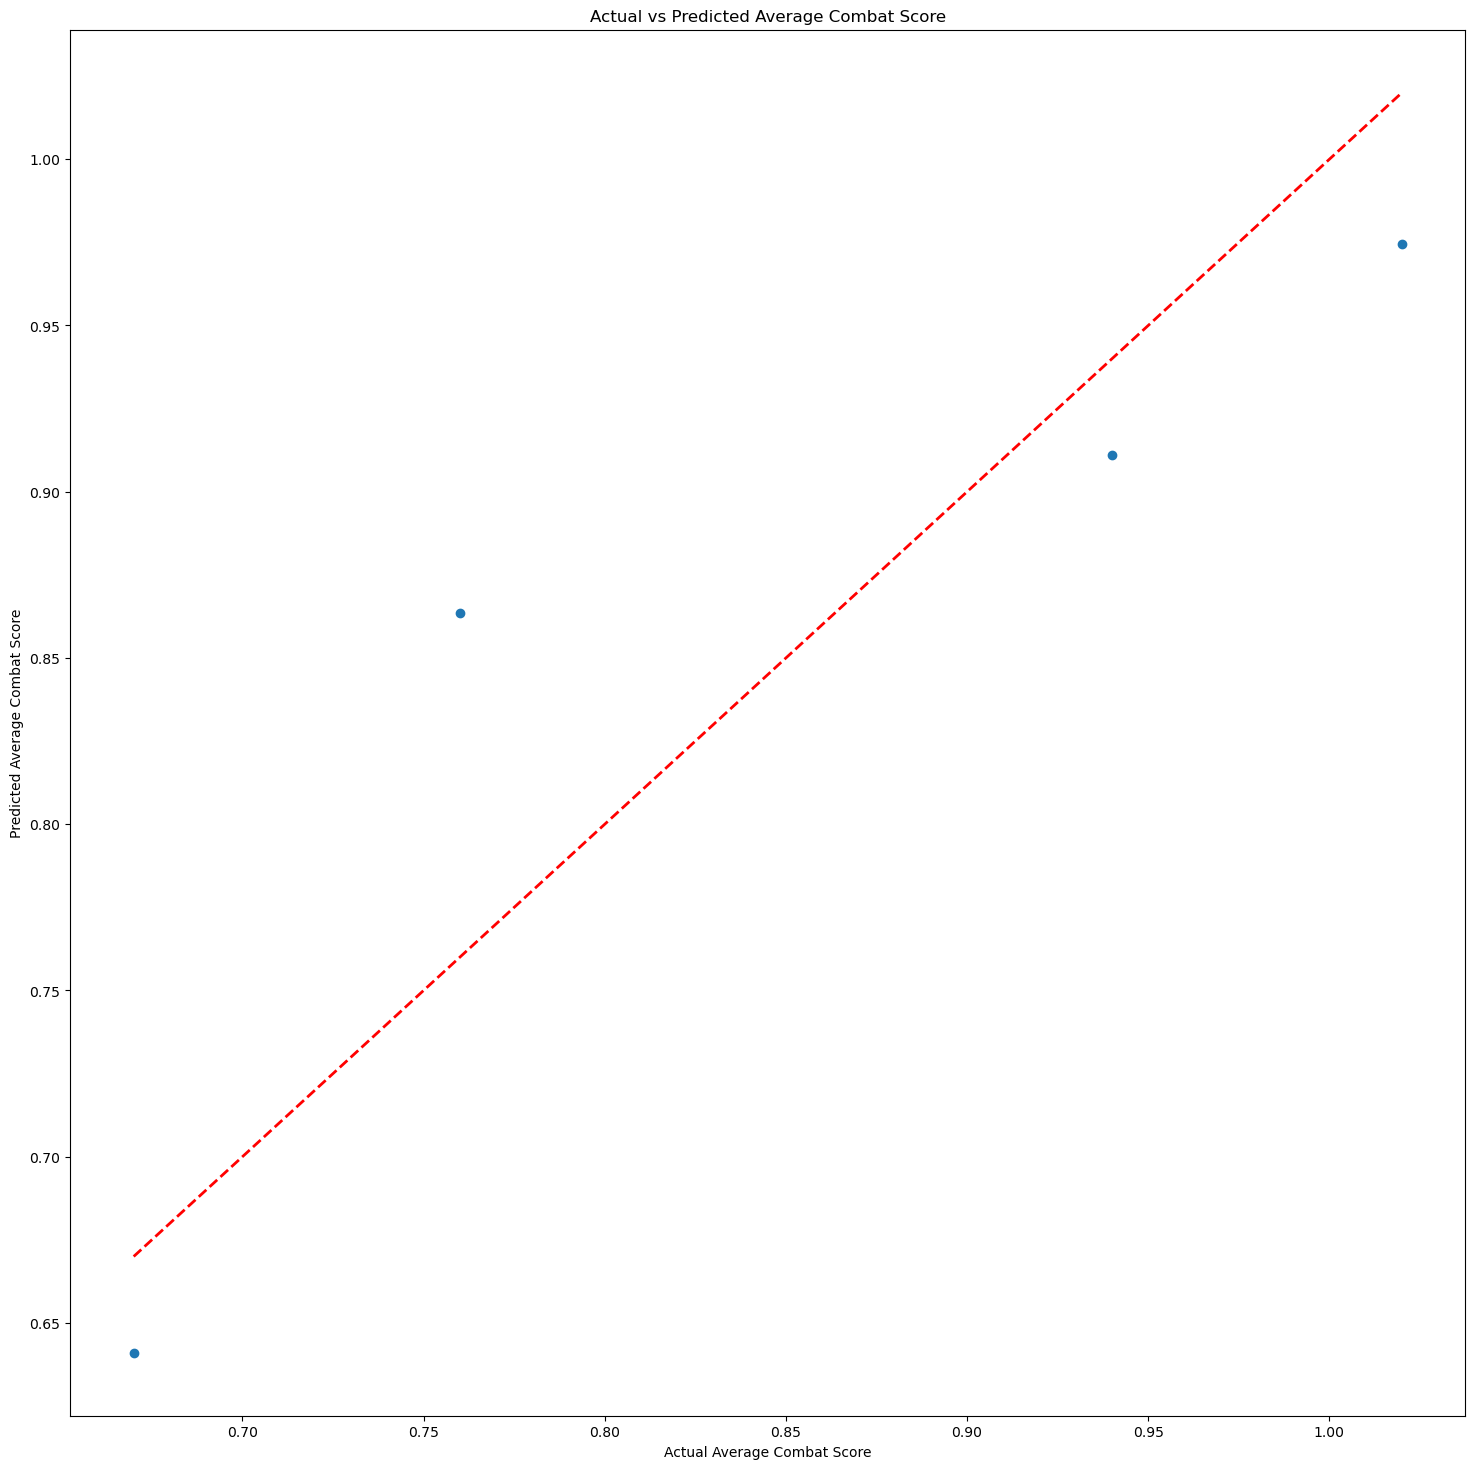

In [31]:
# Actual vs Predicted graph

# Create a larger figure
plt.figure(figsize=(18, 18))

# Plot actual vs predicted values with player names
actual = player_data[feature]
plt.scatter(player_data[feature], prediction_data_actual)
plt.plot([min(actual), max(actual)], [min(actual), max(actual)], linestyle='--', color='red', linewidth=2)
plt.xlabel("Actual Average Combat Score")
plt.ylabel("Predicted Average Combat Score")
plt.title("Actual vs Predicted Average Combat Score")

plt.show()

In [32]:
mse = mean_squared_error(player_data[feature], prediction_data_actual)
mape = mean_absolute_percentage_error(player_data[feature], prediction_data_actual)
r2 = r2_score(player_data[feature], prediction_data_actual)
print(f'Mean Squared Error: {mse}')
print(f'mean_absolute_percentage_error: {mape}')
print(f'R-squared: {r2}')

Mean Squared Error: 0.0036078499999999997
mean_absolute_percentage_error: 0.06365469008131078
R-squared: 0.8137282994514359


In [29]:
#Beta model on one feature and player
feature = 'kills_per_round'
player_beta_model = BetaRegression(data, feature)

In [30]:
player_data = data.loc[data['player'] == 'TenZ']

player_beta_model.fit(player_data['months_from_Jan_2021'], player_data[feature])

In [31]:
player_data['months_from_Jan_2021']

118     4
119     8
120    11
121    25
Name: months_from_Jan_2021, dtype: int64

In [32]:
player_beta_model.predict(pd.DataFrame({'date': [25, 35]}))

0    0.64106
1    0.48226
dtype: float64

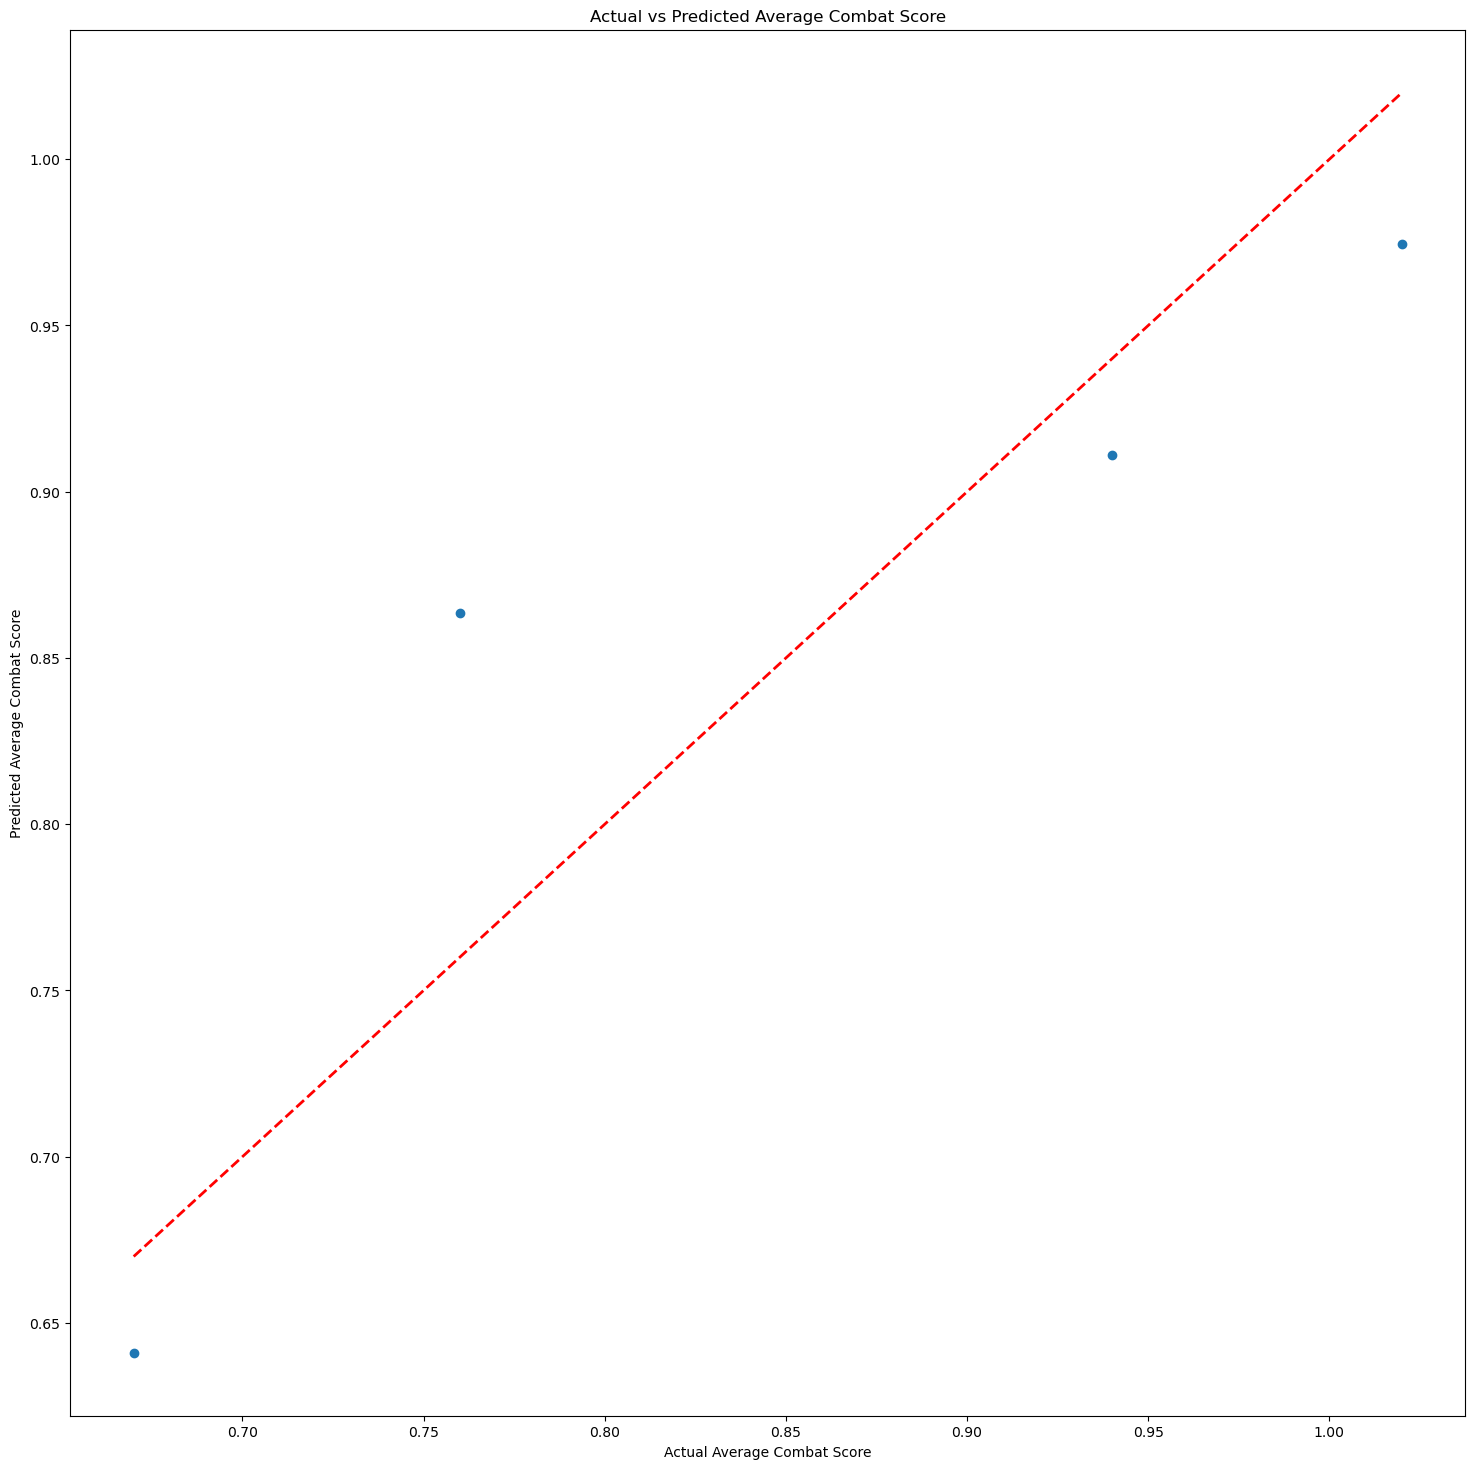

In [33]:
# Actual vs Predicted graph

prediction_data_actual = player_beta_model.predict(player_data['months_from_Jan_2021'])
# Create a larger figure

plt.figure(figsize=(18, 18))

# Plot actual vs predicted values with player names
actual = player_data[feature]
plt.scatter(player_data[feature], prediction_data_actual)
plt.plot([min(actual), max(actual)], [min(actual), max(actual)], linestyle='--', color='red', linewidth=2)
plt.xlabel("Actual Average Combat Score")
plt.ylabel("Predicted Average Combat Score")
plt.title("Actual vs Predicted Average Combat Score")

plt.show()

In [34]:
mse = mean_squared_error(player_data[feature], prediction_data_actual)
mape = mean_absolute_percentage_error(player_data[feature], prediction_data_actual)
r2 = r2_score(player_data[feature], prediction_data_actual)
print(f'Mean Squared Error: {mse}')
print(f'mean_absolute_percentage_error: {mape}')
print(f'R-squared: {r2}')

Mean Squared Error: 0.003607850000000004
mean_absolute_percentage_error: 0.06365469008131078
R-squared: 0.8137282994514357


In [34]:
prediction_data_all = player_beta_model.predict(data['months_from_Jan_2021'].unique())

In [35]:
prediction_data_all

array([0.70458, 0.73634, 0.64106, 0.91102, 0.49814, 0.57754, 0.86338,
       0.97454])

In [37]:
#Predict features of one player
player_data = data.loc[data['player'] == 'TenZ']
player_feature_model = {}
for feature in features:
    player_feature_model_beta = BetaRegression(player_data, feature)
    feature_model = player_feature_model_beta.fit(player_data['months_from_Jan_2021'], player_data[feature])
    player_feature_model.update({feature:feature_model})

In [38]:
#Load ACS model
ACS_model_file_name = 'model.sav'

ACS_model = pickle.load(open(ACS_model_file_name, 'rb'))

In [41]:
player_feature_model.get('kills_per_round')

In [ ]:

filename = 'player_feature_model_beta.sav'
pickle.dump(player_feature_model_beta, open(filename, 'wb'))

In [36]:
#Save Models
filename = 'player_feature_models.sav'
pickle.dump(player_feature_models, open(filename, 'wb'))

NameError: name 'player_feature_models' is not defined

In [ ]:
filename = 'player_feature_models_linear.sav'
pickle.dump(player_feature_models_linear, open(filename, 'wb'))

In [ ]:
filename = 'player_feature_models_XGB.sav'
pickle.dump(player_feature_models_XGB, open(filename, 'wb'))

In [35]:
filename = 'player_feature_models_beta.sav'
pickle.dump(player_feature_models_beta, open(filename, 'wb'))

In [14]:
#Create regression model for each feature for each players
#Note: Unknown players don't work.
#Note: Used linear tree regression due to problems in prediction and small sample per player.
#Note: Prevented negative values
player_feature_models_linear_limited = {}
for player in players:
    player_feature_model = {}
    player_data = data.loc[data['player'] == player]
    for feature in features:
        feature_model = LinearLimitedRegression(data, feature)
        feature_model.fit(player_data['months_from_Jan_2021'].values[:,np.newaxis], player_data[feature])
        player_feature_model.update({feature:feature_model})
    player_feature_models_linear_limited.update({player:player_feature_model})

In [15]:
player_feature_models_linear_limited.get('TenZ').get('kills_per_round')

In [16]:
filename = 'player_feature_models_linear_limited.sav'
pickle.dump(player_feature_models_linear_limited, open(filename, 'wb'))